In [1]:
import scipy as sci
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
%matplotlib widget

file = 'Iris.csv'
data = pd.read_csv(file, index_col=0, header=0).reset_index(drop=True)
N = len(data.index)

cats = data["Species"].unique()
cats1 = dict(zip(cats, range(len(cats))))
cats2 = dict(zip(range(len(cats)), cats))
data["Species"] = data["Species"].apply(lambda x: cats1[x])

x = data.index

## Sampling

### Distributions

Text(0.5, 0, 'Index')

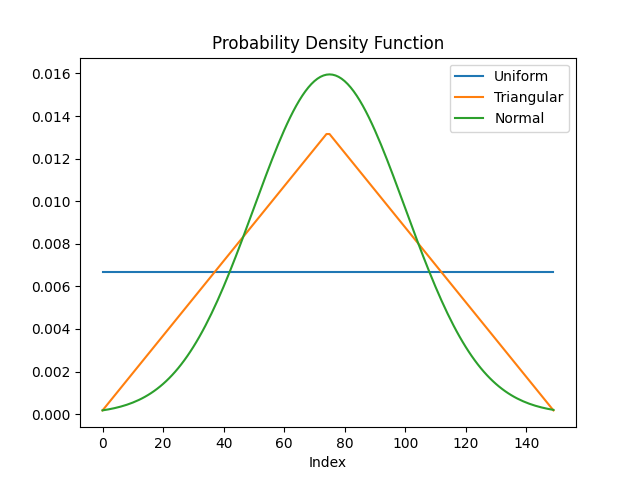

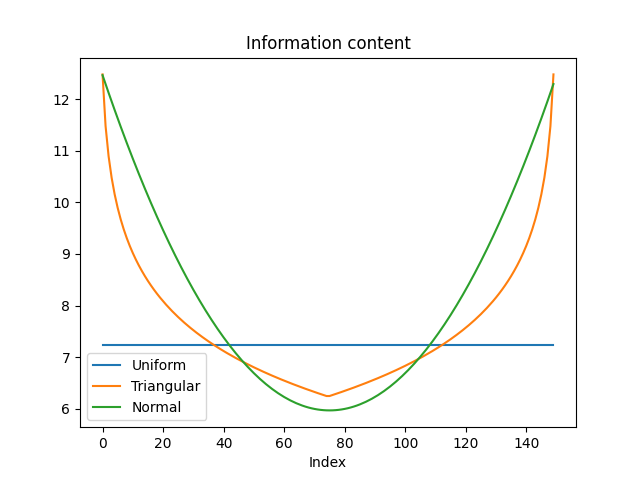

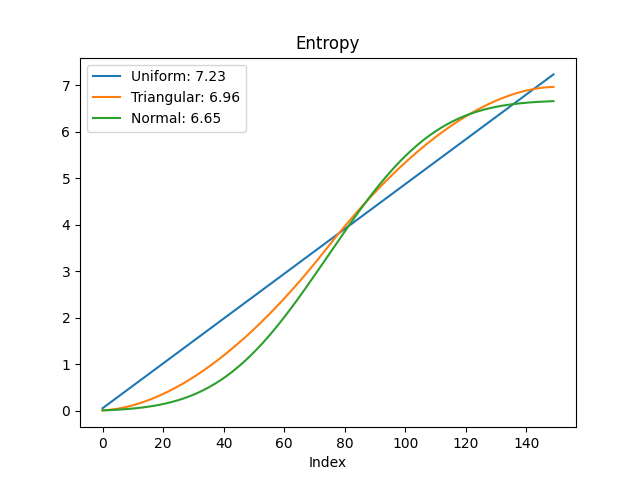

In [5]:
pdf_names = ["Uniform", "Triangular", "Normal"]

def pdf(pdf, x): return {
    "Uniform": sci.stats.uniform.pdf(x, 0, N),
    "Triangular": sci.stats.triang.pdf(x, 0.5, -1, N+1),
    "Normal": sci.stats.norm.pdf(x, N//2, N//6)}[pdf]

plt.figure()
for name in pdf_names:
    plt.plot(x, pdf(name, x), label=name)
plt.legend()
plt.title("Probability Density Function")
plt.xlabel("Index")

plt.figure()
for name in pdf_names:
    p = pdf(name, x)
    I = np.log2(1/p)
    plt.plot(x, I, label=name)
plt.legend()
plt.title("Information content")
plt.xlabel("Index")

plt.figure()
for name in pdf_names:
    p = pdf(name, x)
    H = np.cumsum(-p*np.log2(p))
    plt.plot(x, H, label=f"{name}: {H[-1]:.2f}")
plt.legend()
plt.title("Entropy")
plt.xlabel("Index")


### Sampled

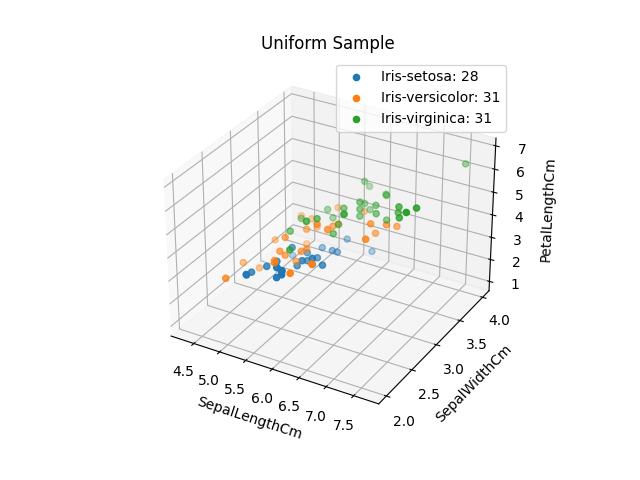

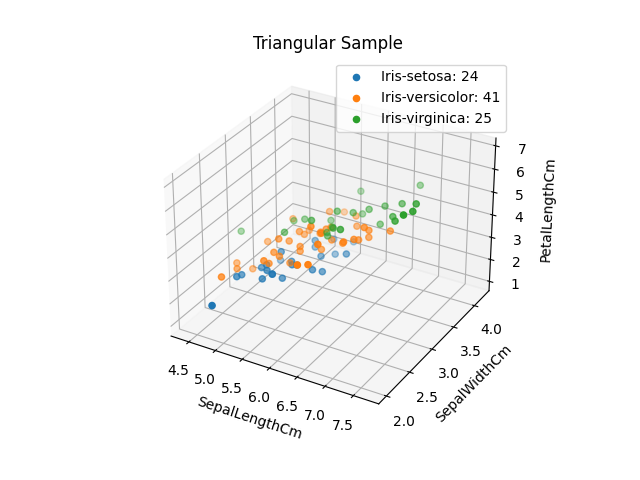

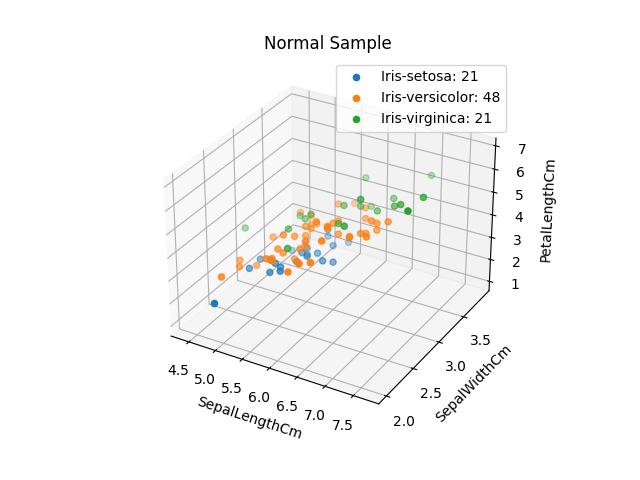

In [3]:
def set_axis_labels(ax, x, y, z):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

for name in pdf_names:
    plt.figure()
    ax = plt.axes(projection='3d', title=f"{name} Sample")
    sample = data.sample(frac=0.6, weights=pdf(name, x))
    for (k, v) in cats1.items():
        p = sample[sample["Species"] == v]
        ax.scatter(*zip(*p.iloc[:, 0:3].values.tolist()),
                   label=f"{k}: {len(p)}")
    plt.legend()
    set_axis_labels(ax, *p.columns[0:3])
